# KNN classifier

This exploration was produced using a combination of the Introduction to Statistical Learning (ISLR) book and scikit-learn documentation.

The K Nearest Neighbors algorithm is a simple classifier algorithm that predicts the label of a new data point based on the the number of training samples closest to it.  

The 3 main steps to this algorithm are as follows:
* Calculate the distance from the new point to all the training samples
* Sort the samples by distance from the new point
* Predict the new point label based on the closest training samples
    * The closest samples are based on a user defined parameter ***K***, wich is the number of points used to determine the new point's label
    
The prediction is made as follows: <sub>(from ISLR: equation 2.12, pg. 39)</sub>
$$Pr(Y = j\mid X = x_o) = \frac{1}{K}\sum_{i\ \in N_o}I(y_i = j)$$ 

where: $I$ is the indicator variable, $x_o$ is the new data point, $N_o$ is the set of points closest to the new data point

The parameter ***K*** has a dramatic affect on the predicted value.
<img src="knn_pic.JPG" alt="mouse drawing skills" title="KNN K value example" />

From my graph showing a data set with a new data point inserted in, the difference between selecting a K value of 3 vs. a K value of 6 is shown.  If we were to choose K to equal 3, then the algorithm would choose the new data point to be in the blue class. If we set K equal to 6, then the new point belongs to the green class.

Choosing a good K value is of high importance to acheiving a good performing model. Low values of K can be too flexible and create an *overfitted* model. A K that is too high will have a high rate of misclassification. 

To check for overfitting, the model can be tested against a test set of data, while iteratively changing K


## MNIST dataset   
Since the matlab book uses this dataset with a KNN classifier, I will explore a KNN classifier application here in python. 

[MNIST dataset website](http://yann.lecun.com/exdb/mnist/)

The MNIST dataset is a collection of handwritten numbers.  It has 60 thousand training samples and 10 thousand test examples. The samples are 28x28 px black and white images of numbers.

The scikit-learn library has the MNIST dataset built in and provides a way to automatically download it.


In [1]:
import pandas as pd
import numpy as np
from sklearn import datasets

In [2]:
mnist_data = datasets.fetch_mldata('MNIST Original')   # pulls data from http://mldata.org/ instead of MNIST website

In [3]:
print('data shape',mnist_data.data.shape)
print('target shape',mnist_data.target.shape)

data shape (70000, 784)
target shape (70000,)


This dataset is made up of 70,000 samples of images. The images are in the form of a 1-D array of 774 greyscale values from 0 to 255. It is the result of a flattened 28 x 28 pixel image.

I think we can check an image out by reshaping a sample and plotting it.

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

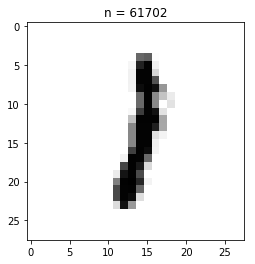

In [5]:
n = np.random.randint(0,70000)                       # selecting a random int between 0 and 70k (just for fun)
sample_image = mnist_data.data[n].reshape(28,28)     # reshape the first entry as a 28 x 28 matrix
plt.imshow(sample_image,cmap='Greys')                # after much trial and tribulation...
plt.title('n = ' + str(n))

## Building a model
I will first try and "homebrew" an algorithm to see if I can get any sort of performance from it. My plan is to use the 3 main steps mentioned above, but first I need to split up the data into a test set and a training set.

### algorithms within algorithms
After reading some the sklearn documentation about KNN, it turns out there are a few different algorithms for determining the distance between observations.  The first and most strait forward is the brute-force method, which literally just takes the difference between each point. This is what I was planning on doing for the homebrew algorithm.  However, the documentation also says that this is only effective for samples of 30 or less.  I have 60,000.

I will try to take a set of 30 random samples and implement the homebrew method. 

In [6]:
toy_X = np.zeros((30,784))
toy_y = np.zeros(30)
for rows in range(30):
    i = np.random.randint(0,60000)
    toy_X[rows] = mnist_data.data[i]
    toy_y[rows] = mnist_data.target[i]
print(toy_X)
print(toy_y)


[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
[ 3.  0.  0.  6.  8.  6.  7.  7.  0.  9.  3.  6.  9.  4.  1.  2.  5.  0.
  4.  9.  9.  1.  6.  8.  3.  8.  7.  5.  9.  0.]


Sk-learn has a little function that performs a split of the data in a random manner and is standard practice for building ML models in python.

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
# splitting data up into sets
X_train, X_test, y_train, y_test = train_test_split(toy_X, toy_y, test_size=10)

### Step 1) Distances
Calculate the distances between the new point and the training points.

Since our observations are not just a scalar value, we cannot simply take the difference between each point. We first have to find the Euclidean distance between each image's "gray-scale intensity vector" <--thus deamed

The distance is calculated as follows:

$d(x,x') = \sqrt{(x_1-x_1')^2 + (x_2-x_2')^2+...+(x_n-x_n')^2}$

where: n = 784 in our case
<sub> cite: [How does KNN work?](https://kevinzakka.github.io/2016/07/13/k-nearest-neighbor/)</sub>

Since I am using the most simplistic method (brute force) I need to compare my 10 test samples to my 20 train samples.  This will create a  10x20 matrix of distances, where the rows are test samples, and columns are distance from training sample.

In [9]:
# function for euclidean distance
def distFun(train,test):
    sum = 0
    for i in range(len(train)):
        sum += (train[i]-test[i])**2
    d = np.sqrt(sum)  
    return d


In [10]:
# generating a list of dictionaries

# create main dictionary
distances = {}
# create sub dictionary
dist = {}
for row in range(len(X_test)):          # for each test sample 
    row_dic = {}                       # create a dictionary for the test samples
    for col in range(len(X_train)):     # for each training sample
        d = distFun(X_test[row],X_train[col])      # compute the distance from the test sample
        key = str(row) + str(col)
        row_dic[str(col)] = {'dist':d, 'label':y_train[col]}   # put the distance into a dictionary referencing the train label
    distances[str(row)] = row_dic                              # add the dictionaries to a dictionary 
        
        

dictionary inception...

In [39]:
distances['0'].keys()

dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19'])

In [46]:
for test in distances.keys():
    for train in distances[test].keys():
        print(distances[test][train]['dist'], distances[test][train]['label'])

2922.60294943 4.0
2723.97522015 1.0
2620.08091478 1.0
2558.44601272 6.0
2738.19356511 8.0
2291.79842045 6.0
2689.26755828 4.0
2334.75180694 0.0
2651.7420689 5.0
2575.23862972 9.0
2933.51018406 3.0
2580.4363972 0.0
2756.11229815 3.0
2921.57645801 9.0
2654.90263475 0.0
2672.82883852 7.0
2605.33491129 3.0
2237.80025918 6.0
2653.17244068 8.0
2520.0015873 9.0
2424.42570519 4.0
2424.98762883 1.0
2241.87555408 1.0
2695.53445535 6.0
2324.99634408 8.0
2349.87999694 6.0
2304.00520833 4.0
2977.91705727 0.0
2427.5230174 5.0
2113.39347969 9.0
2488.06350401 3.0
2468.06118239 0.0
2535.56601176 3.0
2292.83121926 9.0
2642.9562993 0.0
2164.43618525 7.0
2798.77437461 3.0
2723.41697138 6.0
2498.87974901 8.0
1981.49943225 9.0
2768.1620256 4.0
2435.30778342 1.0
2312.88067137 1.0
3065.88209167 6.0
2377.85596704 8.0
2476.5526443 6.0
2256.69382061 4.0
2888.20722941 0.0
2396.83645667 5.0
2198.31412678 9.0
2466.96595031 3.0
2669.49339763 0.0
2790.63111142 3.0
2286.89571253 9.0
2839.60190872 0.0
1332.38170207 7.0

### Step 2) Sort
I can now sort the matrix of distances. I will sort the distances for each row in ascending order.


In [152]:
sorted(distances, key=distances['0']['0']['dict'])

KeyError: 'dict'

### Step 3) Predict
Now I can take the ***K*** nearest points from the test values to predict what number it is.

Since the test samples are sorted in ascending order, the ***K*** value will corespond to the number of elements we consider, starting from index 0.

Then we can check to see what train samples corespond to each element. Our prediction will be based on which train sample is most prevalent in the set of ***K*** values.

In [21]:
def tally(arr,K):
    

0.0

In [34]:
y_train

array([ 7.,  1.,  4.,  0.,  4.,  6.,  6.,  6.,  8.,  3.,  4.,  8.,  1.,
        0.,  2.,  3.,  7.,  5.,  2.,  1.])

In [63]:
a = [1,3,2,5,4]
b = [4,3,1,6,4]
c = [[a],[b]]
print(c)


[[[1, 3, 2, 5, 4]], [[4, 3, 1, 6, 4]]]


In [64]:
np.sort(c,axis=1)

array([[[1, 3, 2, 5, 4]],

       [[4, 3, 1, 6, 4]]])